### In this Notebook i iterate over the models options to get a baseline

In [1]:
import tensorflow
from keras import Sequential, Input,layers,models
import numpy as np
import pandas as pd
import librosa

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

2025-12-09 14:19:03.389916: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-09 14:19:04.196312: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-09 14:19:07.374672: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
from pathlib import Path
import sys, os

# Find the repo root by walking up until we find 'utils'
repo_root = Path.cwd()
while not (repo_root / "utils").exists():
    if repo_root.parent == repo_root:
        raise RuntimeError("Cannot find repo root containing 'utils' from cwd: " + str(Path.cwd()))
    repo_root = repo_root.parent

# Prepend repo_root so `from utils...` works
sys.path.insert(0, str(repo_root))
print("Added to sys.path:", repo_root)

# Now import
from utils.create_table import create_table

Added to sys.path: /home/edgar/code/Arkyed/08-Project/databass-code/DataBass


In [3]:
### using model/dense.py fonctions and utils create_table_from_csv we're gonne to create X and y our features and target

audio_files_paths = '/home/edgar/code/Arkyed/08-Project/databass-code/DataBass/raw_data/IDMT-SMT-AUDIO-EFFECTS/IDMT-SMT-AUDIO-EFFECTS/IDMT-SMT-AUDIO-EFFECTS/Bass monophon2/Bass monophon2/Samples/Overdrive'

create_table()
table = pd.read_csv('table_correspondance_notes_basse.csv')

Table créée


In [4]:
table

,corde,case,note,fréquence (Hz)
0,E,0,E1,41.20
1,E,1,F1,43.65
2,E,2,F♯1,46.25
3,E,3,G1,49.00
4,E,4,G♯1,51.91
...,...,...,...,...
95,G,20,D♯4,311.13
96,G,21,E4,329.63
97,G,22,F4,349.23
98,G,23,F♯4,370.00


In [5]:
from extract.chorus_bass_extract import extract_chorus_bass_list

In [6]:
WORKING_DIR = os.environ.get('WORKING_DIR')
extract_chorus_bass_list(WORKING_DIR)

Loading chorus bass data from /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/raw_data/Bass monophon/Lists/Chorus...
                 fileID instrument instrumentsetting playstyle midinr string  \
0  B33-28100-3311-00989          B                 3         3     28      1   
1  B33-29101-3311-00990          B                 3         3     29      1   
2  B33-30102-3311-00991          B                 3         3     30      1   
3  B33-31103-3311-00992          B                 3         3     31      1   
4  B33-32104-3311-00993          B                 3         3     32      1   

  fret fxgroup fxtype fxsetting filenr note_name  \
0   00       3     31         1  00989        E1   
1   01       3     31         1  00990        F1   
2   02       3     31         1  00991       F#1   
3   03       3     31         1  00992        G1   
4   04       3     31         1  00993       G#1   

                                           file_path  
0  Bass monophon/Samples

In [7]:
chorus_bass_list = pd.read_csv(f'{WORKING_DIR}/data/preprocessed/chorus_bass_list.csv')
chorus_bass_list.sample()

,fileID,instrument,instrumentsetting,playstyle,midinr,string,fret,fxgroup,fxtype,fxsetting,filenr,note_name,file_path
1379,B53-39301-3313-02472,B,5,3,39,3,1,3,31,3,2472,D#2,Bass monophon/Samples/Chorus/B53-39301-3313-02...


In [8]:
len(chorus_bass_list['note_name'].unique())

28

In [9]:
wave, sr = librosa.load(WORKING_DIR + '/raw_data/' + chorus_bass_list['file_path'][0])

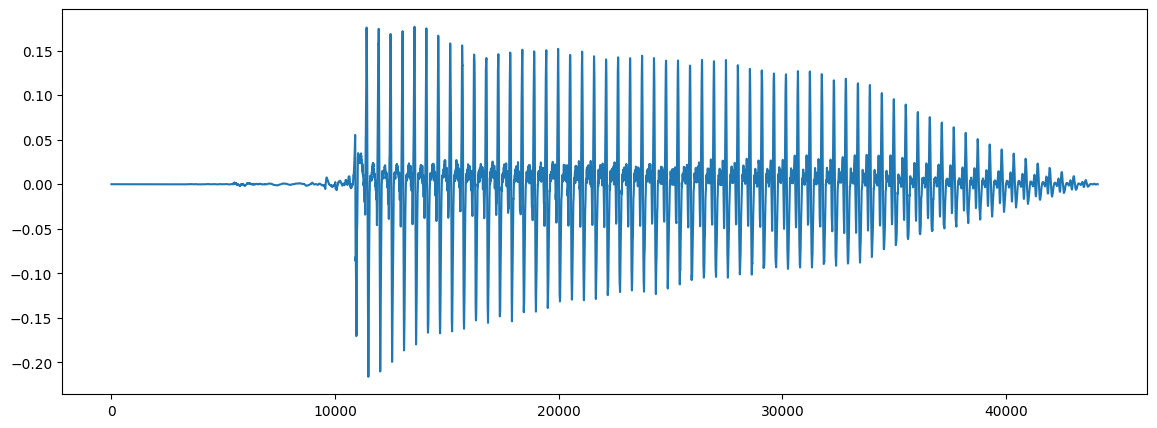

In [10]:
#plot the wave
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
plt.plot(wave)

In [ ]:
length_before = 1000
length_after = 5000

In [40]:
def select_starting_point(y):
    start_ind = 0
    i = 0
    while start_ind==0:
        if y[i] >= 0.9 * y.max():
            start_ind = i
        else:
            i += 1

    y_select = y[start_ind-length_before:start_ind+length_after].copy()
    return y_select


In [ ]:
import numpy as np
import librosa

def load_and_truncate(path, sr=22050):
    """
    Load audio file, resample, and pad/truncate to fixed length.

    Args:
        path (str): Path to audio file
        sr (int): Target sample rate (default 22050 Hz)
        max_len (int): Desired length in samples (default 5 seconds)

    Returns:
        np.ndarray: 1D array of length max_len
    """
    y, _ = librosa.load(path, sr=sr)  # load audio
    #detect starting point of note
    start_ind = 0
    i = 0
    while start_ind==0:
        if y[i] >= 0.9 * y.max():
            start_ind = i
        else:
            i += 1

    y_select = y[start_ind-length_before:start_ind+length_after].copy() # select segment around starting point
    return y

In [48]:
X = chorus_bass_list['file_path'].apply(lambda x : load_and_truncate(WORKING_DIR + '/raw_data/' + x))
y = chorus_bass_list['note_name']

In [51]:
len(X), X.shape, X.dtype, X[0].dtype, X[0].shape

(1872, (1872,), dtype('O'), dtype('float32'), (44101,))

In [13]:
classes = len(y.unique())
classes

28

#### encode y labels aka Notes

In [14]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder()
y_int = le.fit_transform(chorus_bass_list['note_name'])  # integers 0..n_classes-1
y = to_categorical(y_int)

In [31]:
categories = y.shape[1]

In [15]:
X = np.vstack(X.values).astype(np.float32)

X shape: (1872, 110250),X[0].shape: (110250,), y shape: (1872, 28)
Example X[0] length: 110250, y[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


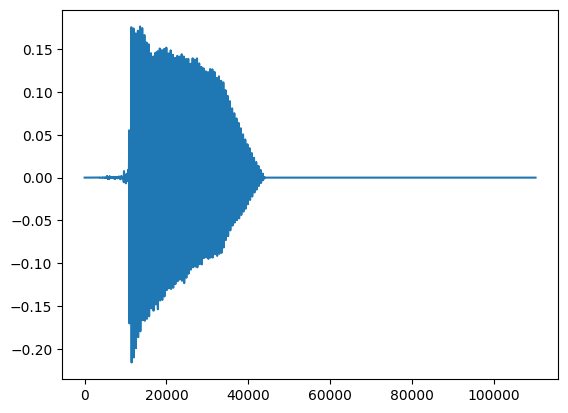

In [16]:
print(f'X shape: {X.shape},X[0].shape: {X[0].shape}, y shape: {y.shape}')
print(f'Example X[0] length: {len(X[0])}, y[0]: {y[0]}')
plt.plot(X[0])

In [17]:
X_features = chorus_bass_list['file_path'].apply(
    lambda x: librosa.feature.mfcc(
        y=librosa.load(WORKING_DIR + '/raw_data/' + x)[0],
        sr=librosa.load(WORKING_DIR + '/raw_data/' + x)[1],
        n_mfcc=13
    ).mean(axis=1)  # average over time → fixed-length vector
)

X = np.vstack(X_features.values).astype(np.float32)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [19]:
unique_notes = len(table.note.unique())
unique_notes

40

In [20]:
X_train[0], y_train[0] , X[0].shape

(array([-675.3087   ,  100.35854  ,   64.499596 ,   42.479042 ,
          29.909126 ,   22.14153  ,   17.004534 ,   13.056838 ,
          10.139022 ,    6.4490504,    2.6307378,   -1.6396327,
          -6.6153893], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 (13,))

In [21]:
input_shape = (X[0].shape[0],1)
input_shape

(13, 1)

In [32]:
## create dense model and compile dense model :
def make_model(input_shape):
    input_layer = layers.Input(shape=input_shape)

    conv1 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)

    gap = layers.GlobalAveragePooling1D()(conv3)

    output_layer = layers.Dense(categories, activation="softmax")(gap)

    return models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape)

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 13, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 13, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 13, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,328 (110.66 KB)

 Trainable params: 27,944 (109.16 KB)

 Non-trainable params: 384 (1.50 KB)

In [34]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [25]:
print(type(X_train))
print(X_train.shape, X_train.dtype)
print(y_train.shape, y_train.dtype)

<class 'numpy.ndarray'>
(1310, 13) float32
(1310, 28) float64


In [35]:
es = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=32, callbacks=[es])

Epoch 1/50


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 28), output.shape=(None, 28)

### test with a random forest

In [ ]:
# create a randomforest model to try and output the note based on the audio file
rf_classifier = RandomForestClassifier(n_estimators=100,random_state=42)

results = rf_classifier.fit(X_train,y_train)
results

In [ ]:
#grid search the random forest
from sklearn.model_selection import GridSearchCV

# Définir une grille d'hyperparamètres
param_grid = {
'n_estimators': [50, 100, 200],
'max_depth': [5, 10, None],
'min_samples_split': [2, 5, 10]
}

# Recherche par grille
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres :", grid_search.best_params_)

Meilleurs paramètres : {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
